# ip data and binary data

In [3]:
from sklearn.utils import shuffle
import pandas as pd

def toint(row):
    row['1st Octet']=int(row['1st Octet'])
    row['2nd Octet']=int(row['2nd Octet'])
    row['3rd Octet']=int(row['3rd Octet'])
    row['4th Octet']=int(row['4th Octet'])
    return row

def ipcleanup(row):
    iprow=[]
    for address in row['A']:
        try:
            tempstring=address.split('IN A')
            iprow.append(tempstring[1].strip())
        except IndexError:  
            pass
    return iprow

def binarizer(cell):
    if cell[0]=="No Answer" or cell[0]=="Timeout":
        return 0
    else:
        return 1

goodcomplete=pd.read_parquet('../parsed data/gooddnsdata')
goodcomplete=goodcomplete.sample(66000)
badcomplete=pd.read_parquet('../parsed data/baddnsdata')

goodcomplete["indicator"]=goodcomplete["indicator"].apply(lambda x:x[0])
goodcomplete.insert(0,'Malicious',0)
badcomplete.insert(0,'Malicious',1)

badcomplete["indicator"]=badcomplete["indicator"].apply(lambda x: x[0])
badcomplete=badcomplete.drop_duplicates(subset="indicator")
##############################################################################
goodcomplete['A']=goodcomplete.apply(ipcleanup,axis="columns")
badcomplete['A']=badcomplete.apply(ipcleanup,axis="columns")

complete = goodcomplete.append(badcomplete,ignore_index=True)
#cut out rows with empty ip
complete=complete[complete['A'].map(lambda x: len(x)>0)]
complete.reset_index(inplace=True)

complete['A']=complete['A'].apply(lambda x:x[0])
expand=complete['A'].str.split(".",-1,expand=True)
complete["1st Octet"]=expand[0]
complete["2nd Octet"]=expand[1]
complete["3rd Octet"]=expand[2]
complete["4th Octet"]=expand[3]

#reorder
complete=complete[['indicator','Malicious', '1st Octet',"2nd Octet","3rd Octet","4th Octet",'A', 'AAAA', 'CAA', 'CNAME', 'DNAME', 'LOC', 'MX','RP', 'SIG', 'SSHFP' ]]
complete[['A', 'AAAA', 'CAA', 'CNAME', 'DNAME', 'LOC', 'MX','RP', 'SIG', 'SSHFP' ]]=complete[['A', 'AAAA', 'CAA', 'CNAME', 'DNAME', 'LOC', 'MX','RP', 'SIG', 'SSHFP' ]].applymap(binarizer)

In [48]:
goodcomplete=goodcomplete[goodcomplete['A'].map(lambda x: len(x)>0)]

In [4]:
from sklearn.preprocessing import OneHotEncoder
complete[['1st Octet',"2nd Octet","3rd Octet","4th Octet"]]=complete[['1st Octet',"2nd Octet","3rd Octet","4th Octet"]].astype(int)


good=complete[:62763]
bad=complete[62763:]

earlybad=bad.head(40000)
latebad=bad.tail(19000)

train=good.head(40000).append(earlybad).sample(frac=1)
test=good.tail(19000).append(latebad).sample(frac=1)

cats=[list(range(0,256)),list(range(0,256)),list(range(0,256)),list(range(0,256)),[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]

encoder=OneHotEncoder(categories=cats)
encodedtrain=encoder.fit_transform(train[["1st Octet","2nd Octet","3rd Octet","4th Octet",'AAAA', 'CAA', 'CNAME', 'DNAME', 'LOC', 'MX', 'RP', 'SIG',
      'SSHFP']])
encodedtest=encoder.fit_transform(test[["1st Octet","2nd Octet","3rd Octet","4th Octet",'AAAA', 'CAA', 'CNAME', 'DNAME', 'LOC', 'MX', 'RP', 'SIG',
      'SSHFP']])


# Logistic Regression

In [3]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
glm=LogisticRegression()

model=glm.fit(encodedtrain,train['Malicious'])
ypred=model.predict(encodedtest)
print(classification_report(test['Malicious'],ypred))


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.67      0.81      0.73     19000
           1       0.75      0.60      0.67     19000

   micro avg       0.70      0.70      0.70     38000
   macro avg       0.71      0.70      0.70     38000
weighted avg       0.71      0.70      0.70     38000



# MLP 

In [4]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

clf=MLPClassifier()

model=clf.fit(encodedtrain,train['Malicious'])
ypred=model.predict(encodedtest)
yprob=model.predict_proba(encodedtest)
print(classification_report(test['Malicious'],ypred))


              precision    recall  f1-score   support

           0       0.69      0.83      0.76     19000
           1       0.79      0.63      0.70     19000

   micro avg       0.73      0.73      0.73     38000
   macro avg       0.74      0.73      0.73     38000
weighted avg       0.74      0.73      0.73     38000



In [61]:
stuff.sort_values(by="Count",ascending=False)

,1st Octet,2nd Octet,Count
3305,104,27,2337
3302,104,24,1633
3303,104,25,1586
3306,104,28,1369
3297,104,18,1349
3307,104,31,1239
3299,104,20,908
5538,183,90,454
459,23,227,445
4688,151,101,416


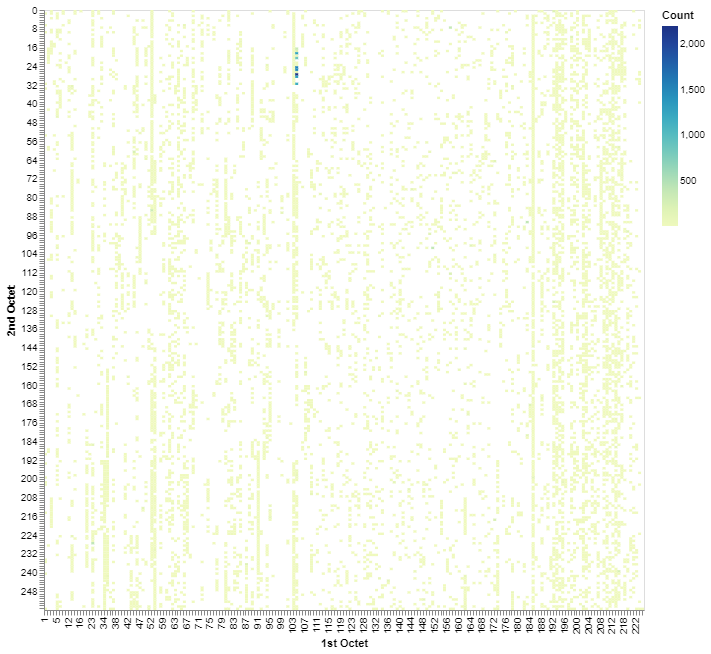

In [119]:
import altair as alt
import numpy as np
import pandas as pd

xgood=good[["1st Octet","2nd Octet"]].sample(59000)
xbad=bad[["1st Octet","2nd Octet"]].sample(59000)

alt.data_transformers.disable_max_rows()
alt.renderers.enable('notebook')
stuffg=xgood.groupby(['1st Octet','2nd Octet']).size().reset_index().rename(columns={0:'Count'})
stuffb=xbad.groupby(['1st Octet','2nd Octet']).size().reset_index().rename(columns={0:'Count'})
stuffgb=pd.concat([stuffg[["1st Octet","2nd Octet"]],stuffb[["1st Octet", "2nd Octet"]]]).drop_duplicates(keep=False)

alt.Chart(stuffg).mark_rect().encode(
    x="1st Octet:O",
    y="2nd Octet:O",
    color="Count").properties(width=600,height=600)

In [151]:
stuffgb=pd.concat([stuffg[["1st Octet","2nd Octet"]],stuffb[["1st Octet", "2nd Octet"]]]).drop_duplicates().sort_values(by=["1st Octet","2nd Octet"])

In [155]:
stuffg

,1st Octet,2nd Octet,Count
0,1,1,4
1,1,6,2
2,1,9,1
3,1,31,1
4,1,33,2
5,1,53,1
6,1,189,1
7,1,193,6
8,1,199,1
9,1,201,1


In [154]:
stuffgb

,1st Octet,2nd Octet
0,0,0
0,1,1
1,1,6
2,1,9
2,1,10
3,1,31
4,1,33
3,1,52
5,1,53
4,1,83


# RANDOM FOREST

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
rfc=RandomForestClassifier()
model=rfc.fit(encodedtrain,train['Malicious'])
ypred=model.predict(encodedtest)
print(classification_report(test['Malicious'],ypred))


/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.70      0.88      0.78     19000
           1       0.84      0.62      0.71     19000

   micro avg       0.75      0.75      0.75     38000
   macro avg       0.77      0.75      0.75     38000
weighted avg       0.77      0.75      0.75     38000



In [18]:
len(list(range(0,256)))*4

1024

In [25]:
sum(rfc.feature_importances_[:1024])

0.7910182074393679

In [22]:
sum(rfc.feature_importances_[1024:])

0.20898179256063168

# QDA

In [ ]:
from sklearn.svm import SVC
supportvec=SVC()
model=supportvec.fit(encodedtrain,train['Benign'])
ypred=model.predict(encodedtest)
print(classification_report(test['Benign'],ypred))


# NEAREST NEIGHBOR

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier()
model=knn.fit(encodedtrain,train['Benign'])
ypred=model.predict(encodedtest)
print(classification_report(test['Benign'],ypred))
